In [1]:
pip install path

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from path import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('crypto_data.csv')

data.head()

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [4]:
# filter to IsTrading = True and drop column
df = data.loc[data["IsTrading"] == True]
trading_data = df.copy(deep=True).drop(columns="IsTrading")

In [6]:
# check for null values
trading_data.isnull()
# drop null values
trading_data = trading_data.dropna()

In [7]:
# validate
trading_data.isnull()

,Unnamed: 0,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,False,False,False,False,False,False
2,False,False,False,False,False,False
4,False,False,False,False,False,False
5,False,False,False,False,False,False
7,False,False,False,False,False,False
...,...,...,...,...,...,...
1238,False,False,False,False,False,False
1242,False,False,False,False,False,False
1245,False,False,False,False,False,False
1246,False,False,False,False,False,False


In [11]:
# filter to coins mined greater than zero
trading_data = trading_data.loc[trading_data["TotalCoinsMined"] > 0]
# drop unnecessary columns
trading_data_to_encode = trading_data.copy(deep=True).drop(columns=["CoinName","Unnamed: 0"])
# check data
trading_data_to_encode.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,Scrypt,PoW/PoS,4.199995e+01,42
2,Scrypt,PoW/PoS,1.055185e+09,532000000
5,X13,PoW/PoS,2.927942e+10,314159265359
7,SHA-256,PoW,1.792718e+07,21000000
8,Ethash,PoW,1.076842e+08,0


In [12]:
# check data types prior to one-hot encoding
trading_data_to_encode.dtypes

Algorithm           object
ProofType           object
TotalCoinsMined    float64
TotalCoinSupply     object
dtype: object

In [14]:
# convert "Total Coin Supply" to float
trading_data_to_encode["TotalCoinSupply"] = trading_data_to_encode["TotalCoinSupply"].astype(float)
trading_data_to_encode.dtypes

Algorithm           object
ProofType           object
TotalCoinsMined    float64
TotalCoinSupply    float64
dtype: object

In [15]:
# check data
trading_data_encoded = pd.get_dummies(trading_data_to_encode)
# scale the data
X = trading_data_encoded
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape

(532, 98)

In [16]:
pca = PCA(n_components=0.90)
principal_components = pca.fit_transform(X_scaled)
print(f"OG Shape: {X_scaled.shape}")
print(f"Dim Reduced Shape: {principal_components.shape}")
print(f"Explained Variance: {pca.explained_variance_.sum()}")
result = tuple(map(lambda i, j: i - j, X_scaled.shape, principal_components.shape))
(rows, features) = result
print(f"Features Removed: {features}")

OG Shape: (532, 98)
Dim Reduced Shape: (532, 74)
Explained Variance: 88.47283457566151
Features Removed: 24


In [17]:
# Reduce dimensions with t-SNE
tsne = TSNE(perplexity=50)
tsne_features = tsne.fit_transform(principal_components)
tsne_features.shape

(532, 2)

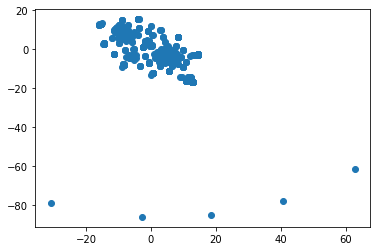

In [18]:
# Plot t-SNE output
X = tsne_features[:,0]
y = tsne_features[:,1]

plt.scatter(X, y)
plt.show()

In [19]:
inertia = []

K = list(range(1,11))
 
for i in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=i, random_state=1).fit(principal_components)
    kmeanModel.fit(principal_components)
    inertia.append(kmeanModel.inertia_)
    print(kmeanModel.inertia_)
    
print("--------")
print(inertia)

D:\python\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
D:\python\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


46979.07515967621
45909.857192674855
45062.02901471952
44194.49799365266
43528.062308147666
42572.56339971649
41580.9343129844
40439.67118107446
39530.996722935364
38846.57456886685
--------
[46979.07515967621, 45909.857192674855, 45062.02901471952, 44194.49799365266, 43528.062308147666, 42572.56339971649, 41580.9343129844, 40439.67118107446, 39530.996722935364, 38846.57456886685]


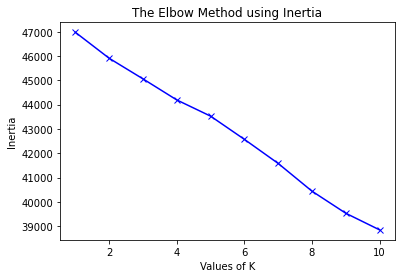

In [20]:
plt.plot(K, inertia, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()